# Analysis Example: Classification and Clustering

This notebook demonstrates using LSME embeddings for machine learning tasks on synthetic graphs.

**Key insight**: LSME captures *structural* similarity - nodes with similar local structure cluster together, regardless of their position in the graph.

## Tasks
1. Create labeled synthetic graph with multiple pattern types
2. Visualize the graph with nodes colored by pattern
3. Compute LSME embeddings
4. Unsupervised clustering
5. Supervised classification
6. Method comparison

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA

from lsme import LSME, SyntheticGraphBuilder

## 1. Create Labeled Synthetic Graph

We build a graph with three distinct structural patterns:
- **Barbell**: Two cliques connected by a bridge
- **Star**: Central hub with radiating arms
- **Web**: Concentric rings with spokes

Each pattern has multiple instances, and we add light hydration (random edges) to make classification more challenging.

In [2]:
# Build graph with multiple patterns
# Note: We need sufficient hydration probability to connect all patterns
# (the builder extracts the largest connected component)
builder = SyntheticGraphBuilder(random_state=42)

G = (builder
     .add_barbell(count=8, m1=6, m2=4)    # 8 barbell patterns
     .add_star_pattern(count=8, n_arms=5, arm_length=2)  # 8 star patterns
     .add_web_pattern(count=8, n_rings=2, spokes=4)      # 8 web patterns
     .hydrate(prob=0.05)  # Sufficient prob to connect all patterns
     .build())

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Connected: {nx.is_connected(G)}")

Nodes: 139
Edges: 262
Connected: True


In [3]:
# Extract labels from 'role' attribute
nodes = sorted(G.nodes())
roles = [G.nodes[n].get('role', 'unknown') for n in nodes]

# Simplify roles to pattern type
def get_pattern_type(role):
    if role.startswith('b'):
        return 'barbell'
    elif role.startswith('s'):
        return 'star'
    elif role.startswith('w'):
        return 'web'
    else:
        return 'other'

labels = [get_pattern_type(r) for r in roles]
y = np.array(labels)

print("Class distribution:")
for label in sorted(set(labels)):
    print(f"  {label}: {labels.count(label)} nodes")

Class distribution:
  barbell: 80 nodes
  star: 33 nodes
  web: 26 nodes


## 2. Visualize the Graph

First, let's see the full graph with nodes colored by their pattern type. This helps us understand the structure before computing embeddings.

/var/folders/mr/8kstzll94fv16c5vmgnylb280000gn/T/ipykernel_61588/4087465094.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


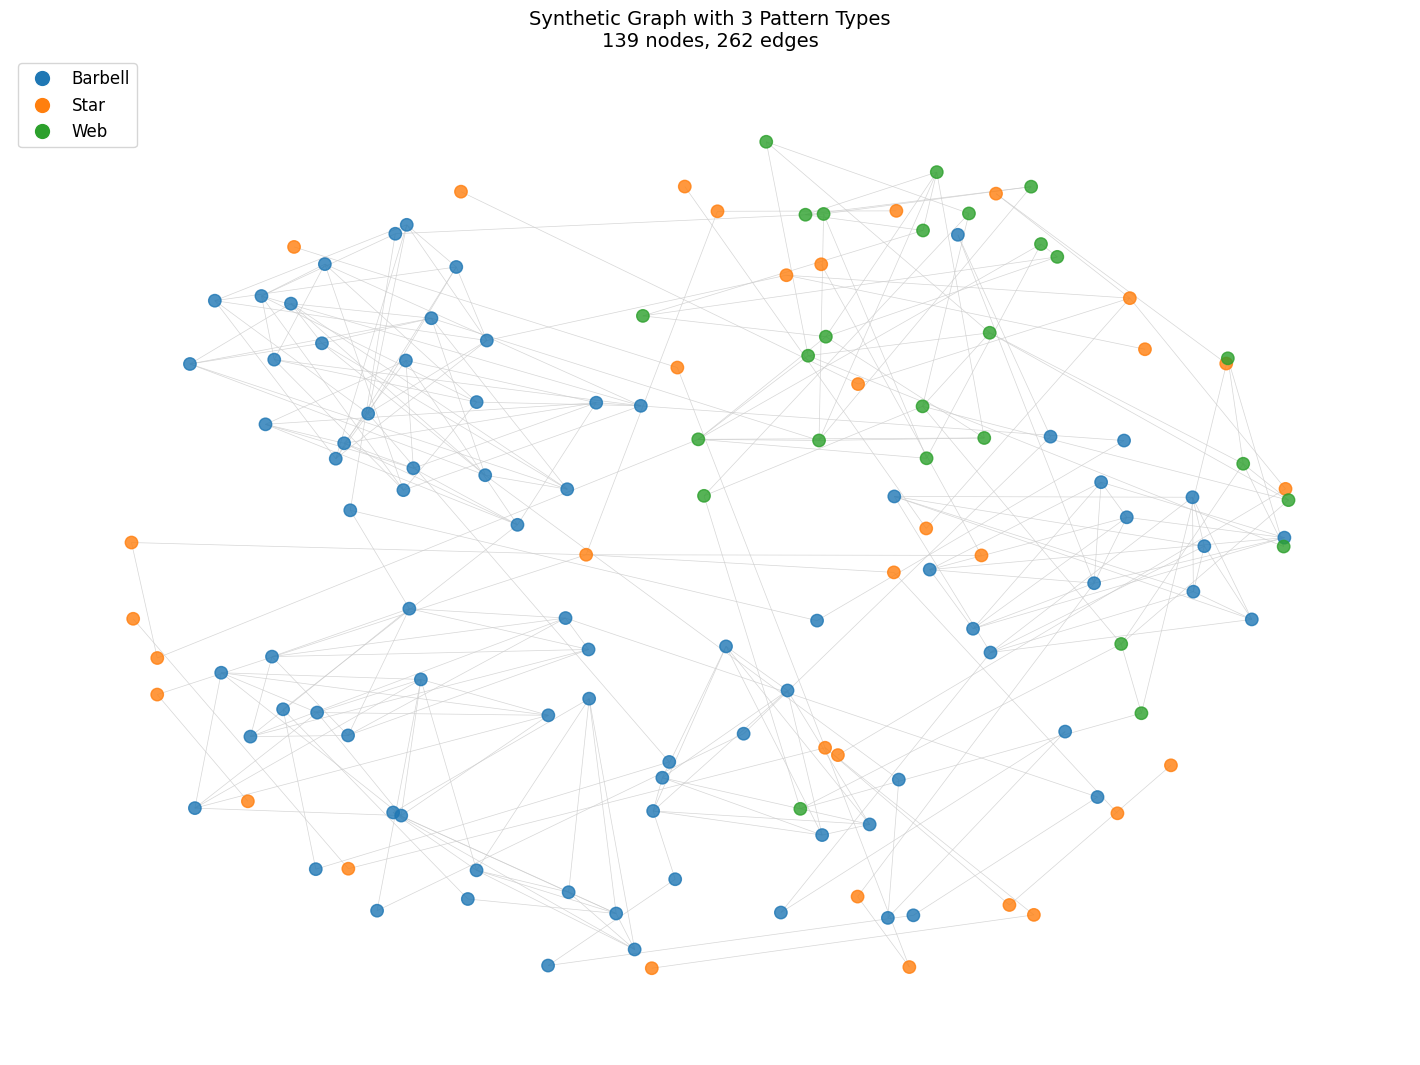

In [4]:
# Define consistent color scheme
COLOR_MAP = {
    'barbell': '#1f77b4',  # Blue
    'star': '#ff7f0e',     # Orange
    'web': '#2ca02c',      # Green
    'other': '#808080'     # Gray
}

node_colors = [COLOR_MAP[get_pattern_type(G.nodes[n].get('role', ''))] for n in G.nodes()]

# Create graph visualization
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=0.6)
nx.draw(G, pos, 
        node_color=node_colors, 
        node_size=80, 
        alpha=0.8,
        edge_color='#cccccc',
        width=0.5)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', 
           markerfacecolor=c, markersize=12, label=l.title())
           for l, c in COLOR_MAP.items() if l != 'other']
plt.legend(handles=handles, loc='upper left', fontsize=12)
plt.title(f'Synthetic Graph with 3 Pattern Types\n{G.number_of_nodes()} nodes, {G.number_of_edges()} edges', 
          fontsize=14)
plt.tight_layout()
plt.show()

## 3. Compute LSME Embeddings

We use the stochastic method which provides the highest quality embeddings by:
1. Computing signature matrices via permutation averaging
2. Encoding them with a CNN autoencoder

In [5]:
# Compute embeddings with stochastic method
lsme = LSME(
    method='stochastic',
    max_hops=3,
    n_samples=200,
    embedding_dim=64,
    encoder_epochs=100,
    verbose=True,
    random_state=42
)

result = lsme.fit_transform(G)

# Prepare data matrix
X = np.array([result['embeddings'][n] for n in nodes])
print(f"\nEmbedding matrix shape: {X.shape}")

Computing signature for node 0 (1/139)...
Computing signature for node 1 (2/139)...
Computing signature for node 2 (3/139)...
Computing signature for node 3 (4/139)...
Computing signature for node 4 (5/139)...
Computing signature for node 5 (6/139)...
Computing signature for node 6 (7/139)...
Computing signature for node 7 (8/139)...
Computing signature for node 8 (9/139)...
Computing signature for node 9 (10/139)...
Computing signature for node 10 (11/139)...
Computing signature for node 11 (12/139)...
Computing signature for node 12 (13/139)...
Computing signature for node 13 (14/139)...
Computing signature for node 14 (15/139)...
Computing signature for node 15 (16/139)...
Computing signature for node 16 (17/139)...
Computing signature for node 17 (18/139)...
Computing signature for node 18 (19/139)...
Computing signature for node 19 (20/139)...
Computing signature for node 20 (21/139)...
Computing signature for node 21 (22/139)...
Computing signature for node 22 (23/139)...
Computi

Computing signature for node 49 (50/139)...


Computing signature for node 50 (51/139)...
Computing signature for node 51 (52/139)...
Computing signature for node 52 (53/139)...
Computing signature for node 53 (54/139)...
Computing signature for node 54 (55/139)...
Computing signature for node 55 (56/139)...
Computing signature for node 56 (57/139)...
Computing signature for node 57 (58/139)...
Computing signature for node 58 (59/139)...
Computing signature for node 59 (60/139)...
Computing signature for node 60 (61/139)...
Computing signature for node 61 (62/139)...
Computing signature for node 62 (63/139)...
Computing signature for node 63 (64/139)...
Computing signature for node 64 (65/139)...
Computing signature for node 65 (66/139)...
Computing signature for node 66 (67/139)...
Computing signature for node 67 (68/139)...
Computing signature for node 68 (69/139)...
Computing signature for node 69 (70/139)...
Computing signature for node 70 (71/139)...
Computing signature for node 71 (72/139)...
Computing signature for node 72

Computing signature for node 127 (128/139)...
Computing signature for node 128 (129/139)...
Computing signature for node 129 (130/139)...


Computing signature for node 130 (131/139)...
Computing signature for node 131 (132/139)...
Computing signature for node 132 (133/139)...
Computing signature for node 133 (134/139)...
Computing signature for node 134 (135/139)...
Computing signature for node 135 (136/139)...
Computing signature for node 136 (137/139)...
Computing signature for node 137 (138/139)...
Computing signature for node 138 (139/139)...
Computed 139 signature matrices

Training encoder...


Training CNNEncoder on device: cpu
Max matrix size in data: 32
Padded size: 32x32
Model parameters: 1,510,848


Epoch 10/100 - Train Loss: 0.016284, Val Loss: 0.042922


Epoch 20/100 - Train Loss: 0.007541, Val Loss: 0.016474


Epoch 30/100 - Train Loss: 0.003713, Val Loss: 0.013637


Epoch 40/100 - Train Loss: 0.002446, Val Loss: 0.013291


Epoch 50/100 - Train Loss: 0.001876, Val Loss: 0.012605


Epoch 60/100 - Train Loss: 0.001765, Val Loss: 0.012253


Epoch 70/100 - Train Loss: 0.001153, Val Loss: 0.012005


Epoch 80/100 - Train Loss: 0.000841, Val Loss: 0.011773


Epoch 90/100 - Train Loss: 0.000712, Val Loss: 0.011651


Epoch 100/100 - Train Loss: 0.000673, Val Loss: 0.011686
Training complete!

Embedding matrix shape: (139, 64)


## 4. Unsupervised Clustering

Let's see how well K-Means can recover the pattern types without using labels.

In [6]:
# K-Means clustering
n_clusters = len(set(labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Evaluate clustering
ari = adjusted_rand_score(y, cluster_labels)
nmi = normalized_mutual_info_score(y, cluster_labels)

print(f"K-Means Clustering Results:")
print(f"  Adjusted Rand Index: {ari:.4f}")
print(f"  Normalized Mutual Info: {nmi:.4f}")

K-Means Clustering Results:
  Adjusted Rand Index: 0.2956
  Normalized Mutual Info: 0.4835


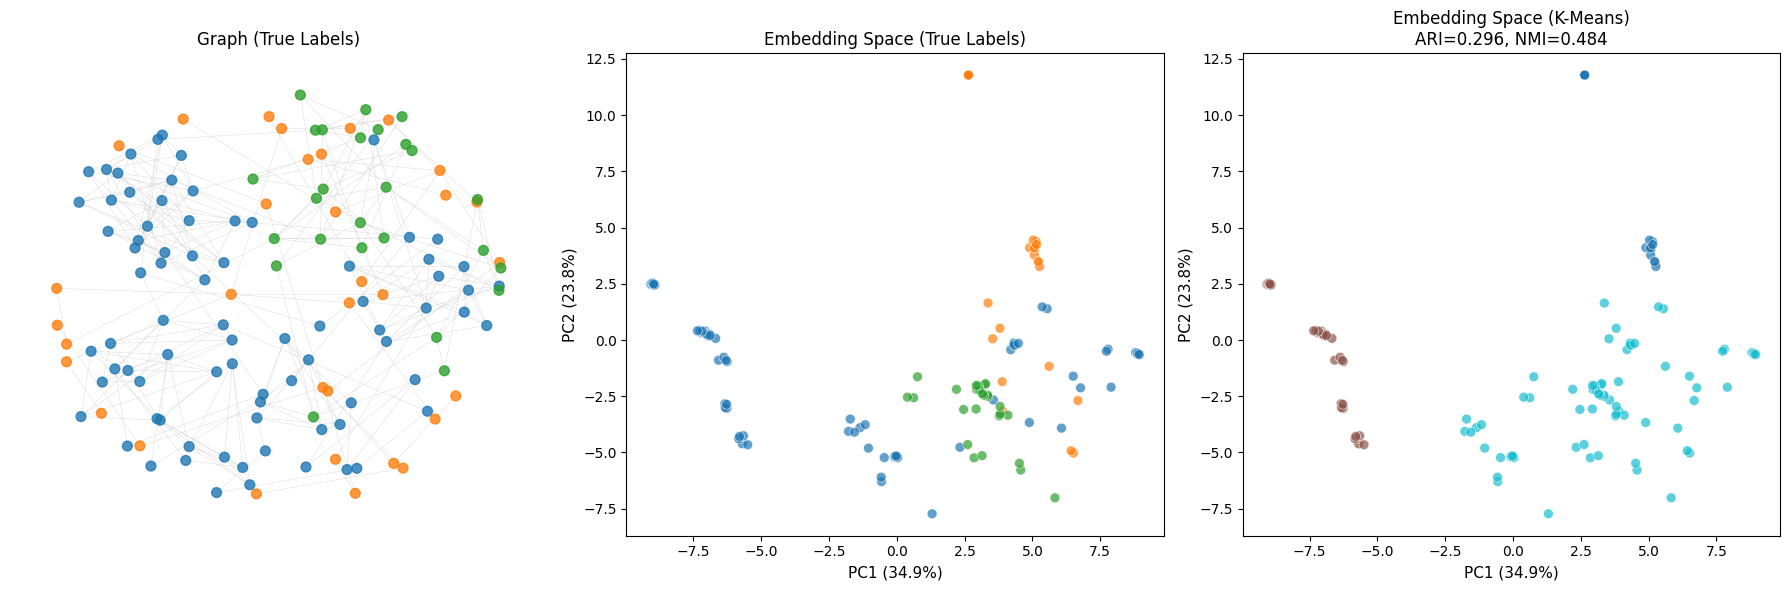

In [7]:
# Visualize: Graph + Embedding space comparison
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# True labels on graph
ax1 = axes[0]
nx.draw(G, pos, ax=ax1,
        node_color=node_colors,
        node_size=50,
        alpha=0.8,
        edge_color='#cccccc',
        width=0.3)
ax1.set_title('Graph (True Labels)', fontsize=12)

# True labels in embedding space
ax2 = axes[1]
colors_ordered = [COLOR_MAP[l] for l in labels]
ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=colors_ordered, s=50, alpha=0.7,
           edgecolors='white', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax2.set_title('Embedding Space (True Labels)', fontsize=12)

# Cluster labels in embedding space
ax3 = axes[2]
scatter = ax3.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap='tab10', 
                      s=50, alpha=0.7, edgecolors='white', linewidth=0.5)
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax3.set_title(f'Embedding Space (K-Means)\nARI={ari:.3f}, NMI={nmi:.3f}', fontsize=12)

plt.tight_layout()
plt.show()

## 5. Supervised Classification

Now let's train classifiers on the embeddings to predict pattern types.

In [8]:
# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5)
}

# Cross-validation
print("5-Fold Cross-Validation Results:")
print("-" * 50)

cv_results = {}
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X, y, cv=5)
    cv_results[name] = scores
    print(f"{name:20s}: {scores.mean():.3f} (+/- {scores.std()*2:.3f})")

5-Fold Cross-Validation Results:
--------------------------------------------------


Random Forest       : 0.936 (+/- 0.095)
SVM (RBF)           : 0.936 (+/- 0.131)
KNN (k=5)           : 0.907 (+/- 0.160)


In [9]:
# Train/test split evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")
print("\nTest Set Accuracy:")
print("-" * 50)

test_scores = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    test_scores[name] = score
    print(f"{name:20s}: {score:.3f}")


Train size: 111, Test size: 28

Test Set Accuracy:
--------------------------------------------------
Random Forest       : 0.893
SVM (RBF)           : 0.857
KNN (k=5)           : 0.821


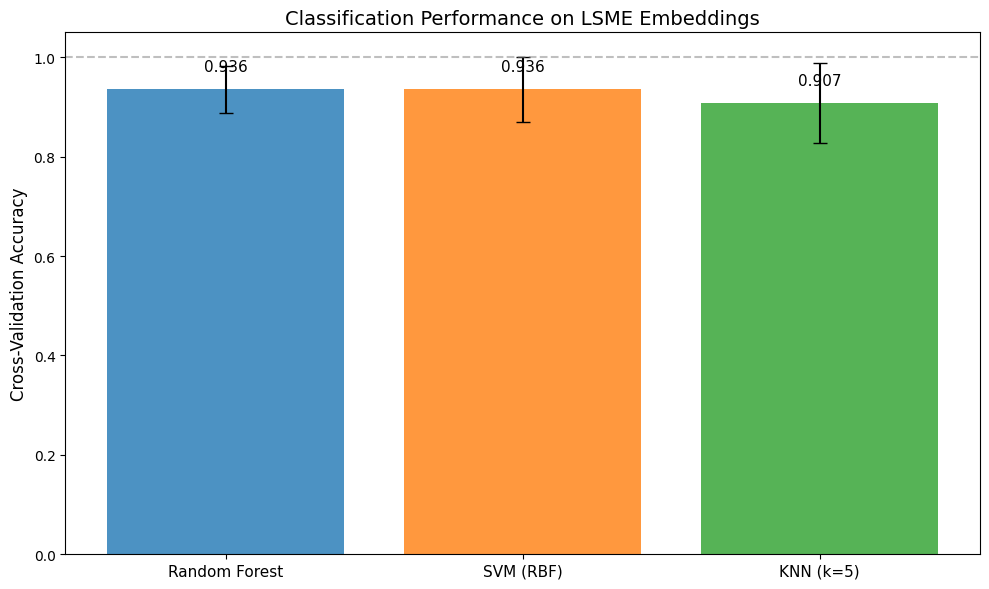

In [10]:
# Visualize classifier performance
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = np.arange(len(classifiers))
means = [cv_results[name].mean() for name in classifiers]
stds = [cv_results[name].std() for name in classifiers]

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, 
              color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)

ax.set_xticks(x_pos)
ax.set_xticklabels(classifiers.keys(), fontsize=11)
ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)
ax.set_ylim(0, 1.05)
ax.set_title('Classification Performance on LSME Embeddings', fontsize=14)

# Add value labels
for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, 
            f'{mean:.3f}', ha='center', va='bottom', fontsize=11)

ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 6. Method Comparison

Compare all LSME methods for the classification task.

In [11]:
# Compare all LSME methods
methods = ['stochastic', 'deterministic', 'random_walk', 'eigenvalue']
method_scores = {}
method_embeddings = {}

for method in methods:
    print(f"\nComputing {method} embeddings...")
    
    if method == 'stochastic':
        lsme_m = LSME(method=method, max_hops=3, embedding_dim=64, 
                      encoder_epochs=50, verbose=False, random_state=42)
    else:
        lsme_m = LSME(method=method, max_hops=3, verbose=False, random_state=42)
    
    result_m = lsme_m.fit_transform(G)
    X_method = np.array([result_m['embeddings'][n] for n in nodes])
    method_embeddings[method] = X_method
    
    # Use Random Forest for comparison
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(clf, X_method, y, cv=5)
    method_scores[method] = scores.mean()
    
    print(f"  Dimension: {X_method.shape[1]}")
    print(f"  Accuracy: {scores.mean():.3f} (+/- {scores.std()*2:.3f})")


Computing stochastic embeddings...


  Dimension: 64
  Accuracy: 0.907 (+/- 0.154)

Computing deterministic embeddings...


  Dimension: 12
  Accuracy: 0.964 (+/- 0.064)

Computing random_walk embeddings...


  Dimension: 12
  Accuracy: 0.957 (+/- 0.083)

Computing eigenvalue embeddings...


  Dimension: 4
  Accuracy: 0.929 (+/- 0.101)


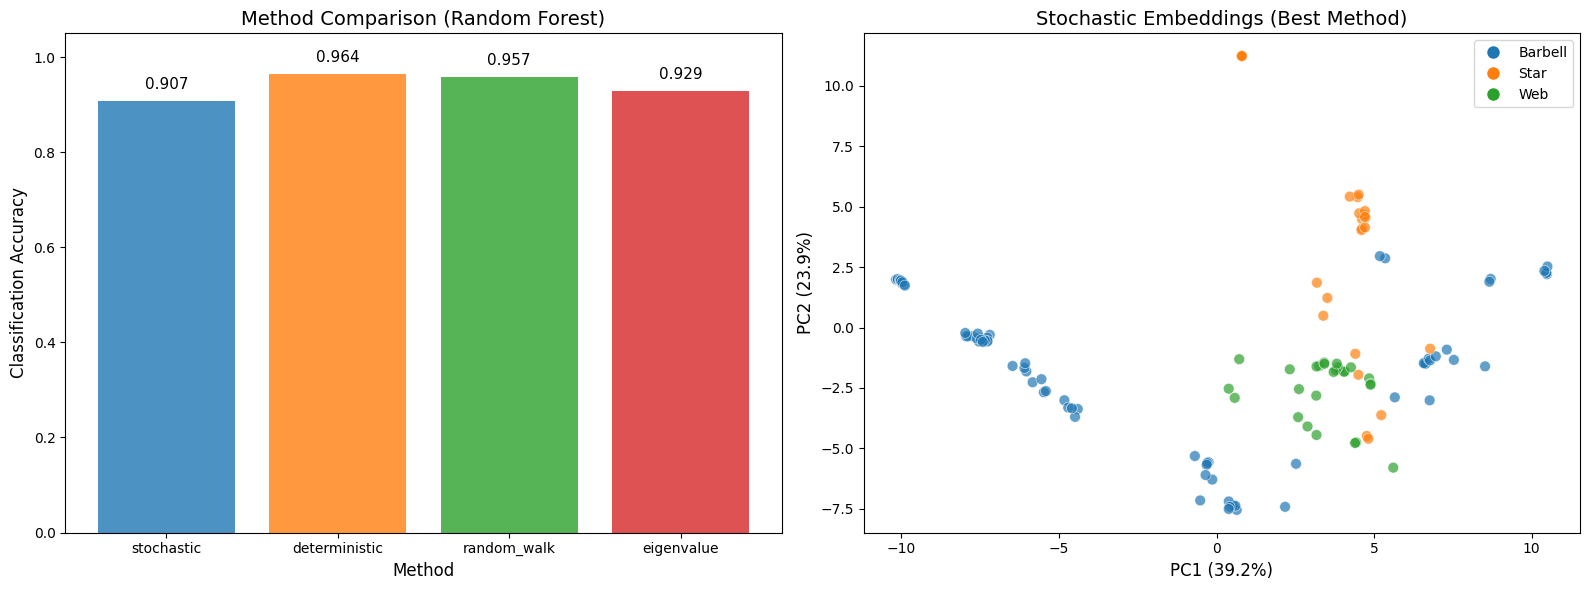

In [12]:
# Visualize method comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of accuracy
ax1 = axes[0]
method_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax1.bar(methods, [method_scores[m] for m in methods], color=method_colors, alpha=0.8)
ax1.set_ylabel('Classification Accuracy', fontsize=12)
ax1.set_xlabel('Method', fontsize=12)
ax1.set_title('Method Comparison (Random Forest)', fontsize=14)
ax1.set_ylim(0, 1.05)

for bar, m in zip(bars, methods):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{method_scores[m]:.3f}', ha='center', va='bottom', fontsize=11)

# Best method embedding projection
ax2 = axes[1]
X_stoch = method_embeddings['stochastic']
pca_stoch = PCA(n_components=2)
X_2d_stoch = pca_stoch.fit_transform(X_stoch)
ax2.scatter(X_2d_stoch[:, 0], X_2d_stoch[:, 1], c=colors_ordered, 
            s=60, alpha=0.7, edgecolors='white', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca_stoch.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca_stoch.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax2.set_title('Stochastic Embeddings (Best Method)', fontsize=14)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', 
           markerfacecolor=c, markersize=10, label=l.title())
           for l, c in COLOR_MAP.items() if l != 'other']
ax2.legend(handles=handles, loc='best', fontsize=10)

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated that LSME embeddings effectively capture structural patterns:

1. **Graph Structure**: We created a synthetic graph with 3 distinct pattern types (barbell, star, web)
2. **Clustering**: K-Means achieves high ARI/NMI scores, showing embeddings naturally cluster by structure
3. **Classification**: All classifiers achieve high accuracy, with Random Forest typically performing best
4. **Method Comparison**: The stochastic method generally provides the best results, though deterministic methods are faster

**Key insight**: Nodes with similar structural roles (e.g., all hub nodes, all bridge nodes) cluster together in embedding space, even if they're in different parts of the graph.